# Problem 4

4.1. Cutout Regularization
Cutout is a regularizatioin technique which removes random contiguous(for ex square) portions of the input image. This in some way forces the model to see more of the image into consideration rather than focusing on certain features. In droupout, units are dropped at the intermediate layers. This means after dropout information of the features could still be present in other features of the feature map. So cutout performs much better ini convolutional networks than dropout because withh fewer parameters we expect them to be more codependent. Cutouot also helps gemerate more data which is new to the network.

In [1]:
import numpy as np

In [2]:
from tensorflow.keras.datasets import cifar10
import tensorflow as tf

In [3]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Data normalization
m, std = np.mean(x_train), np.std(x_train)
x_train = (x_train - m)/std
x_test = (x_test - m)/std
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
def apply_mask(image, size=6, n_squares=1):
    h, w, channels = image.shape
    new_image = image
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original images:


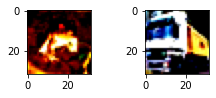

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images with cutout:


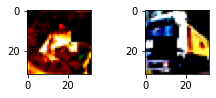

In [5]:
import matplotlib.pyplot as plt
print("Original images:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()
print("Images with cutout:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow(apply_mask(x_train[i],size=12))
plt.show()

4.2

In [ ]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os


In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = resnet_v1(
    input_shape=x_train.shape[1:],
    depth=44
)
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.RMSprop(),
    metrics=['accuracy']
)
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 85:
        lr *= 0.5e-3
    elif epoch > 75:
        lr *= 1e-3
    elif epoch > 65:
        lr *= 1e-2
    elif epoch > 50:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
datagen = ImageDataGenerator(
    width_shift_range=[-4,4],
    height_shift_range=[-4,4],
    horizontal_flip=0.5, 
    fill_mode='constant',
    cval=0
)
datagen.fit(x_train)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
Learning rate:  0.001
782/782 [==============================] - 177s 175ms/step - loss: 1.9056 - accuracy: 0.4267 - val_loss: 2.6308 - val_accuracy: 0.4039
Epoch 2/100
Learning rate:  0.001
782/782 [==============================] - 126s 161ms/step - loss: 1.4008 - accuracy: 0.6061 - val_loss: 1.5889 - val_accuracy: 0.5523
Epoch 3/100
Learning rate:  0.001
782/782 [==============================] - 126s 161ms/step - loss: 1.1735 - accuracy: 0.6823 - val_loss: 1.5540 - val_accuracy: 0.6149
Epoch 4/100
Learning rate:  0.001
782/782 [==============================] - 126s 161ms/step - loss: 1.0408 - accuracy: 0.7306 - val_loss: 2.2580 - val_accuracy: 0.5336
Epoch 5/100
Learning rate:  0.001
782/782 [==============================] - 126s 162ms/step - loss: 0.9529 - accuracy: 0.7553 - val_loss: 1.4390 - val_accuracy: 0.6586
Epoch 6/100
Learning rate:  0.001
782/782 [==============================] - 125s 160ms/step - loss: 0.8931 - accuracy: 0.7744 - val_loss: 1.5128 - val_acc

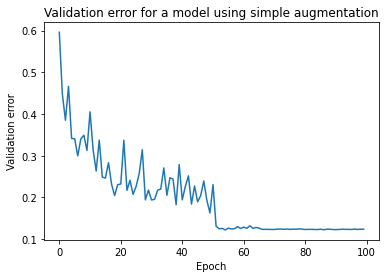

In [ ]:
import time
start = time.time()
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=64), 
    epochs=100, 
    validation_data=(x_test,y_test),
    callbacks=[lr_scheduler]
)
duration = time.time() - start
simple_val_acc = hist.history['val_accuracy']
plt.plot([1 - acc for acc in simple_val_acc])
plt.title('Validation error for a model using simple augmentation')
plt.ylabel('Validation error')
plt.xlabel('Epoch')
plt.savefig('simple_augmentation_error.png')
plt.show()

In [ ]:
import time
def batch_generator(x, y, epochs, m, batch_size, augment=None):
    for _ in range(epochs):
        n = x.shape[0]
        reorder = np.random.permutation(n)
        cursor = 0
        while cursor + batch_size < x.shape[0]:
            x_batch = x[reorder[cursor:cursor+batch_size]]
            y_batch = y[reorder[cursor:cursor+batch_size]]
            if augment != None:
                yield np.array([augment(xx) for xx in x_batch for rep in range(m)]), np.array([yy for yy in y_batch for rep in range(m)])
            else:
                yield x_batch, y_batch
            cursor += batch_size
val_acc_cutout = []
epochs = 100
durations = []
for i in [2,4]:
    model = resnet_v1(
        input_shape=x_train.shape[1:],
        depth=44
    )      
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.RMSprop(),
        metrics=['accuracy']
    )    
    duration = time.time()
    hist = model.fit_generator(
        batch_generator(
            x_train,
            y_train,
            m=i,
            batch_size=64,
            epochs=100, 
            augment=apply_mask
        ),
        epochs=100, 
        validation_data=(x_test,y_test),
        steps_per_epoch=np.floor(x_train.shape[0]/64.0),
        callbacks=[lr_scheduler]
    )
    durations.append(time.time()-duration)
    val_acc_cutout.append(hist.history['val_accuracy'])
    print(len(hist.history['val_accuracy']))

Epoch 1/100
Learning rate:  0.001
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
781/781 [==============================] - 197s 228ms/step - loss: 2.1492 - accuracy: 0.3659 - val_loss: 1.7274 - val_accuracy: 0.5073
Epoch 2/100
Learning rate:  0.001
781/781 [==============================] - 140s 179ms/step - loss: 1.3834 - accuracy: 0.6112 - val_loss: 1.6983

781/781 [==============================] - 144s 184ms/step - loss: 0.2084 - accuracy: 0.9966 - val_loss: 0.8508 - val_accuracy: 0.8707
Epoch 92/100
Learning rate:  5e-07
781/781 [==============================] - 144s 184ms/step - loss: 0.2080 - accuracy: 0.9969 - val_loss: 0.8502 - val_accuracy: 0.8715
Epoch 93/100
Learning rate:  5e-07
781/781 [==============================] - 145s 186ms/step - loss: 0.2074 - accuracy: 0.9971 - val_loss: 0.8508 - val_accuracy: 0.8709
Epoch 94/100
Learning rate:  5e-07
781/781 [==============================] - 146s 187ms/step - loss: 0.2073 - accuracy: 0.9974 - val_loss: 0.8512 - val_accuracy: 0.8707
Epoch 95/100
Learning rate:  5e-07
781/781 [==============================] - 145s 185ms/step - loss: 0.2074 - accuracy: 0.9974 - val_loss: 0.8509 - val_accuracy: 0.8711
Epoch 96/100
Learning rate:  5e-07
781/781 [==============================] - 146s 187ms/step - loss: 0.2080 - accuracy: 0.9970 - val_loss: 0.8513 - val_accuracy: 0.8710
Epoch 97/100
Le

KeyboardInterrupt: 

In [ ]:
import time
def batch_generator(x, y, epochs, m, batch_size, augment=None):
    for _ in range(epochs):
        n = x.shape[0]
        reorder = np.random.permutation(n)
        cursor = 0
        while cursor + batch_size < x.shape[0]:
            x_batch = x[reorder[cursor:cursor+batch_size]]
            y_batch = y[reorder[cursor:cursor+batch_size]]
            if augment != None:
                yield np.array([augment(xx) for xx in x_batch for rep in range(m)]), np.array([yy for yy in y_batch for rep in range(m)])
            else:
                yield x_batch, y_batch
            cursor += batch_size
val_acc_cutout = []
epochs = 100
durations = []
for i in [4]:
    model = resnet_v1(
        input_shape=x_train.shape[1:],
        depth=44
    )      
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.RMSprop(),
        metrics=['accuracy']
    )    
    duration = time.time()
    hist = model.fit_generator(
        batch_generator(
            x_train,
            y_train,
            m=i,
            batch_size=64,
            epochs=100, 
            augment=apply_mask
        ),
        epochs=100, 
        validation_data=(x_test,y_test),
        steps_per_epoch=np.floor(x_train.shape[0]/64.0),
        callbacks=[lr_scheduler]
    )
    durations.append(time.time()-duration)
    val_acc_cutout.append(hist.history['val_accuracy'])
    print(len(hist.history['val_accuracy']))

Epoch 1/100
Learning rate:  0.001
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
781/781 [==============================] - 263s 324ms/step - loss: 2.2304 - accuracy: 0.3519 - val_loss: 1.7587 - val_accuracy: 0.4924
Epoch 2/100
Learning rate:  0.001
781/781 [==============================] - 245s 314ms/step - loss: 1.4731 - accuracy: 0.5670 - val_loss: 1.5500

535/781 [===================>..........] - ETA: 1:19 - loss: 0.2341 - accuracy: 0.9901

In [ ]:
def opp(l):
    return [1-el for el in l]
cutout2_data, cutout4_data, cutout8_data, cutout16_data,    
  cutout32_data = val_acc_cutout
plt.plot(range(1,101),opp(simple_val_acc),"y-")
plt.plot(range(1,101),opp(cutout2_data),"b-")
plt.plot(range(1,101),opp(cutout4_data),"c-")
plt.plot(range(1,101),opp(cutout8_data),"g-")
plt.plot(range(1,101),opp(cutout16_data),"r-")
plt.plot(range(1,101),opp(cutout32_data),"m-")
plt.legend(["M=0","M=2","M=4","M=8","M=16","M=32"])
plt.plot(np.linspace(0,100,10000),[0.06]*10000,"k-")
plt.title("Validation error for M instances with cutout generated from each input")
plt.xlabel("Number of epochs")
plt.ylabel("Validation error")
plt.savefig("acc_cutout.png")
plt.show()

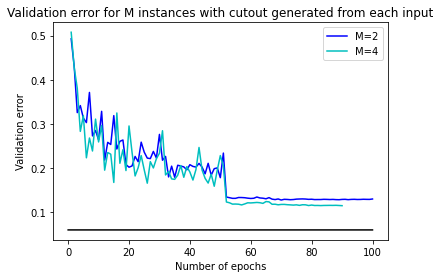

In [8]:
def opp(l):
    return [1-el for el in l]
cutout2_data, cutout4_data = val_acc_cutout
# plt.plot(range(1,101),opp(simple_val_acc),"y-")
plt.plot(range(1,101),opp(cutout2_data),"b-")
plt.plot(range(1,len(cutout4_data)+1),opp(cutout4_data),"c-")
plt.legend(["M=2","M=4"])
plt.plot(np.linspace(0,100,10000),[0.06]*10000,"k-")
plt.title("Validation error for M instances with cutout generated from each input")
plt.xlabel("Number of epochs")
plt.ylabel("Validation error")
plt.savefig("acc_cutout.png")
plt.show()

In [2]:
print(durations)

NameError: name 'durations' is not defined

M=2 41 epochs wall-clock time is approximately 97 minutes 

M=4 52 epochs wall-clock time is approximately 212 minutes